In [1]:
import obspy
from obspy import read, UTCDateTime
from obspy.io.xseed import Parser
from obspy.signal import PPSD
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.cm import pqlx
import os
from obspy.clients.fdsn import Client
from obspy.clients import fdsn
import waveformUtils
from fractions import Fraction

In [6]:
# setting up parameters

# define start and end time for the data range
start_date = UTCDateTime(2023, 8, 22) # Start time
end_date = UTCDateTime(2023, 8, 23) # End time
delta = 86400  # 1 day in seconds
stas = [2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 
        'G2301', 'G2302', 'G2303', 'G2304', 'G2305', 'G2306', 'G2307', 'G2308', 'G2309', 'G2310', 'G2311',
        'G2312', 'G2313', 'G2314', 'G2315', 'G2316'] 
stas = ['ZE.2303..GPZ']  # Station IDs

# set station info
nowsta = stas[0]
network, station, location, channel = nowsta.split('.')
print(f"Using station: {nowsta}")

# define path where .mseed files are stored
path = 'C:/Users/zzawol/Documents/seismic-data-iris/seismic_data/NO2303/GPZ'

# check if the path exists, create if not
if not os.path.exists(path):
    print(f"Path '{path}' does not exist. Creating directory...")
    os.makedirs(path, exist_ok=True)
else:
    print(f"Path '{path}' already exists.")

file_pattern = f'{path}/{network}.{station}.*.{channel}*.mseed'

# set up IRIS client
DATASELECT = 'http://service.iris.edu/ph5ws/dataselect/1'
c = fdsn.client.Client(
    service_mappings={
        'dataselect': DATASELECT,
    },
)

# IRIS credentials
username = 'zoe_zawol@partner.nps.gov'
password = 'rJXKed4LZUHUE05g'
c.set_credentials(username, password)

# set up metadata
client = Client("IRISPH5", timeout=600)
#inv = client.get_stations(network='ZE', station=stas[0], channel='GPZ', level='response')  # adjust as needed
inv = client.get_stations(network=network, station=station, location=location, channel=channel, level='response') 

Using station: ZE.2303..GPZ
Path 'C:/Users/zzawol/Documents/seismic-data-iris/seismic_data/NO2303/GPZ' already exists.


In [12]:
## function to get data from IRIS
def get_iris_data(t1, t2, stas, path):
    """Function to get data from IRIS if not already downloaded"""
    tNow = t1  # start time
    extract_delta = 1800 # 30 mins in seconds

    while tNow < t2:
        for nowsta in stas:
            print(f"Checking data for station {nowsta} from {tNow} to {tNow + extract_delta}")

            # create list of existing .mseed files that already exist in the path
            existing_files = [f for f in os.listdir(path) if f.endswith('.mseed')]

            # construct filename pattern to match for this time period
            filename_pattern = f'{network}.{station}..{channel}_{tNow.strftime("%Y%m%d%H%M%S")}.mseed'

            # check if any required .mseed files are already downloaded
            file_exists = False
            for filename in existing_files: # loop through files in path
                if filename_pattern in filename: # check if filename meets the pattern
                    file_exists = True # if so set to True
                    break

            if file_exists:
                print(f"Data for {nowsta} from {tNow} to {tNow + extract_delta} already exists. Skipping download.")
                continue
            else:
                print(f"Retrieving data for {nowsta} from {tNow} to {tNow + extract_delta}")
                try:
                    # retrieve data from IRIS
                    S = c.get_waveforms(network, station, location, channel, tNow, tNow + extract_delta)
                    print(f"Data for {nowsta} retrieved successfully.")

                    # resample the data
                    print('Resampling data...')
                    S.resample(350)  # resample to 350 Hz/s

                    # save data to .mseed files
                    print('Saving data to .mseed files...')
                    for tr in S:
                        # create filename using starttime of trace with .mseed file format
                        filename = os.path.join(path, f'{tr.id}_{tr.stats.starttime.strftime("%Y%m%d%H%M%S")}.mseed')
                        tr.write(filename)
                        print(f"Saved {filename}")
                except Exception as e:
                    print(f"Error retrieving data for {nowsta} from {tNow} to {tNow + extract_delta}: {e}")
        
        tNow += extract_delta  # move to next interval

    print('Data retrieval and saving completed.')

# call function independently if only want data
#get_iris_data(t1=start_date, t2=end_date, stas=stas, path=path)

In [8]:
# function to plot spectrogram
def plot_spectrogram(S, t1, t2):
    """Function to plot RSAM and Spectrogram"""
    S.merge(method=1) # merge traces to avoid duplicates

    f1 = waveformUtils.multiDaySpectrogram(S, averageLength=3600, fftLength=60, minFreq=0.5, maxFreq=150, cmap='turbo',
                                           dateLimits=None, vmin=0.4, vmax=0.9, plotAverage=True)

    # if just running this cell, comment out f1.show() and plt.show() to avoid displaying twice
    f1.show()
    plt.show() # won't display each loop in main function without this line
    plt.close()
    return f1

# call function independently - uncomment below and comment out .show()s ^
# end=end_date+(6*60)
# S = obspy.read(file_pattern, starttime=start_date, endtime=end)
# plot_spectrogram(S,t1=start_date,t2=end)

In [9]:
# function to plot ppsd and temporal plot
def plot_ppsd(S, inv, t1, t2, user_values):
    """Function to calculate and plot PPSD and Temporal Plot"""
    S.merge(method=1) # merge traces to avoid duplicates
    S.resample(300) # resample
    
    # initialize PPSD object
    ppsd = None
    for tr in S:
        if ppsd is None:
            ppsd = PPSD(tr.stats, metadata=inv, period_limits=(1/150, 10.0))
            # this format possibly avoids re-iterating over individual traces/re-creating PPSD object within loop
            #ppsd = PPSD(S[0].stats, metadata=inv, period_limits=(1/150, 10.0))  # adjust period limits

        ppsd.add(tr)
        print('Trace added to PPSD')

    # plot PPSD for the current day
    if ppsd is not None and len(ppsd.times_processed) > 0:
        print(f"Data accumulated for {(t2-t1)/(60*60*24)}-day periods starting on {t1}")
        ppsd.plot(period_lim=(0.1,150),cmap=pqlx,xaxis_frequency=True) # if xaxis_frequency=False, set period_lim=(1/150,10)
        plt.close() # prevents from displaying each iteration
        
        # plot temporal plot if user values are provided
        if user_values:
            print(f"Plotting temporal plot for periods: {user_values}")
            ppsd.plot_temporal(user_values) # plot temporal plot with user values
            plt.show()
            plt.close()
        
        # save the plot as .png
        #plot_filename = f"ppsd_plot_{t1.date}.png" # change title if more than one date
        #plt.savefig(plot_filename)
        #print(f"Plot saved as {plot_filename}")

    else:
        print(f"No PPSD data accumulated for {t1} to {t2}")
        
    return ppsd


Processing data for 2023-08-22T00:00:00.000000Z to 2023-08-23T00:00:00.000000Z
Checking if any missing data for 2023-08-22T00:00:00.000000Z to 2023-08-23T00:00:00.000000Z, downloading if necessary.
Checking data for station ZE.2303..GPZ from 2023-08-22T00:00:00.000000Z to 2023-08-22T00:30:00.000000Z
Data for ZE.2303..GPZ from 2023-08-22T00:00:00.000000Z to 2023-08-22T00:30:00.000000Z already exists. Skipping download.
Checking data for station ZE.2303..GPZ from 2023-08-22T00:30:00.000000Z to 2023-08-22T01:00:00.000000Z
Data for ZE.2303..GPZ from 2023-08-22T00:30:00.000000Z to 2023-08-22T01:00:00.000000Z already exists. Skipping download.
Checking data for station ZE.2303..GPZ from 2023-08-22T01:00:00.000000Z to 2023-08-22T01:30:00.000000Z
Data for ZE.2303..GPZ from 2023-08-22T01:00:00.000000Z to 2023-08-22T01:30:00.000000Z already exists. Skipping download.
Checking data for station ZE.2303..GPZ from 2023-08-22T01:30:00.000000Z to 2023-08-22T02:00:00.000000Z
Data for ZE.2303..GPZ from

C:\Users\zzawol\AppData\Local\Temp\1\ipykernel_20644\3384900800.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f1.show()


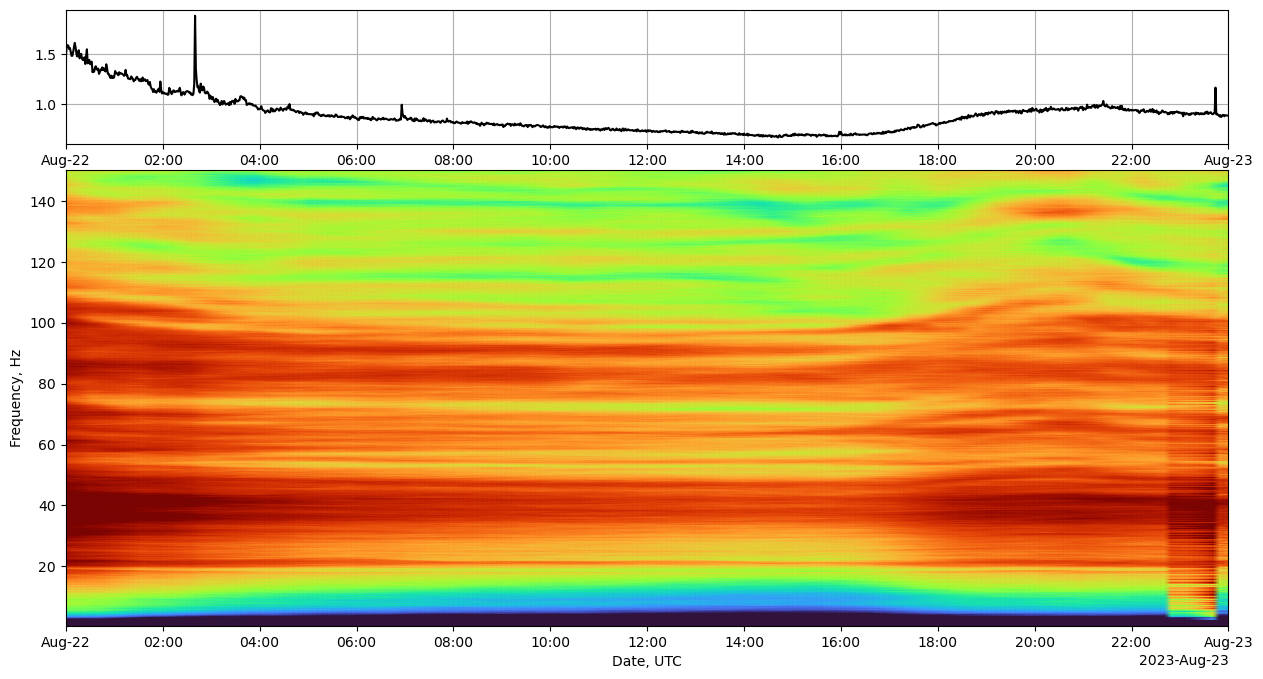

Enter frequency values for temporal plot (comma-separated, takes in fractions and decimals):


Example (0.5, 50, 1/100) :  20, 40, 90


periods: [0.05, 0.025, 0.011111111111111112]
freqs: [20.0, 40.0, 90.0]
Trace added to PPSD
Data accumulated for 1.0-day periods starting on 2023-08-22T00:00:00.000000Z


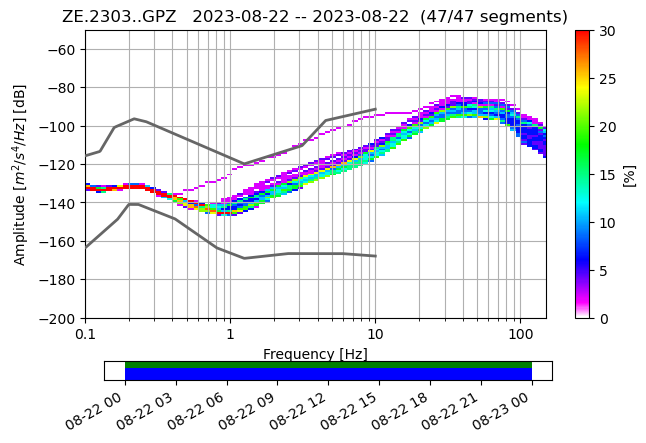

Plotting temporal plot for periods: [0.05, 0.025, 0.011111111111111112]


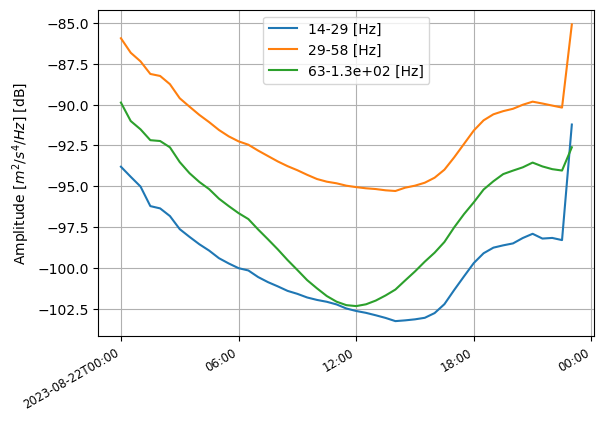

Inputted frequencies: [20.0, 40.0, 90.0] --> periods: ['0.0500', '0.0250', '0.0111']
Analysis for ['ZE.2303..GPZ'] from 2023-08-22T00:00:00.000000Z to 2023-08-23T00:00:00.000000Z complete.


In [11]:
# main function to process data
def process_data(start_date, end_date, stas, path):
    """Main function to run through each day of data in timeframe and perform analyses"""
    delta = 86400  # 1 day in seconds
    current_date = start_date
    
    while current_date < end_date:
        t1 = current_date
        t2 = current_date + delta  # the next day
        print(f"\nProcessing data for {t1} to {t2}")

        try:
            # reading local data for current date range
            S = obspy.read(file_pattern, starttime=t1, endtime=t2)
            print(f"Length of S: {len(S)}")
            
            # use get_iris_data to ensure the data for this time range is downloaded
            # handles downloading only missing parts of the data
            print(f"Checking if any missing data for {t1} to {t2}, downloading if necessary.")
            get_iris_data(t1, t2, stas, path)  # downloads any missing data if necessary

            # after calling get_iris_data, re-read local data (after ensuring it's downloaded)
            S = obspy.read(file_pattern, starttime=t1, endtime=t2)
            print(f"Length of S: {len(S)}")
            
            # plot spectrogram
            S1 = S.copy()  # create a copy of the original stream
            print("Copy of S created")
            print(f"Length of S1: {len(S1)}")

            # read an extra 6 mins of data to extend the stream
            spec_end = t2 + (6 * 60)  # 6 minutes beyond original end time
            S_ext = obspy.read(file_pattern, starttime=t2, endtime=spec_end)  # read only the extra data
            print(f"Length of S_ext: {len(S_ext)}")

            # merge extra 6 mins of data with copied stream (now the whole time range is 6 mins longer)
            S1.extend(S_ext)
            print(f"Length of S1: {len(S1)}")
            
            print("Making spectrogram")
            # now S1 contains the original data plus the extra 6 minutes, and S is untouched
            f1 = plot_spectrogram(S1, t1, spec_end)  # pass S1 to plot_spectrogram function

            # ask user for frequency values after spectrogram
            print("Enter frequency values for temporal plot (comma-separated, takes in fractions and decimals):")
            user_inputs = input("Example (0.5, 50, 1/100) : ").split(',')
            
            # process user input - converts fractions and regular floats
            user_freqs = []
            user_periods = []
            for freq in user_inputs:
                try:
                    freq = freq.strip()  # clean up extra spaces
                    if '/' in freq:
                        user_freqs.append(float(Fraction(freq)))  # handle fraction
                    else:
                        user_freqs.append(float(freq))  # handle float
                except ValueError:
                    print(f"Invalid input: {freq}. Using default values.")

            user_periods = [1 / freq for freq in user_freqs]  # converts to periods for temporal plot
            print('periods:', user_periods)
            print('freqs:', user_freqs)

            # if user didn't provide any valid values, set defaults
            if not user_freqs:
                print("No valid input detected. Using default frequency values.")
                user_freqs = [100, 10, 1]  # default frequencies in Hz

            # plot PPSD
            print("Making PPSD and Temporal Plots")
            # plot_ppsd(S, inv, t1, t2, user_values)
            plot_ppsd(S, inv, t1, t2, user_periods)
            
            round_periods = ['%.4f' % per for per in user_periods]
            print(f"Inputted frequencies: {user_freqs} --> periods: {round_periods}")  # for checking
            # print(user_values)  # for checking
            
        except Exception as e:
            print(f"An error occurred while processing data from {t1} to {t2}: {e}")
        
        current_date += delta  # move to next day

# Call function
process_data(start_date, end_date, stas, path)
print(f"Analysis for {stas} from {start_date} to {end_date} complete.")